In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 12225.62it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [15]:
from ai2thor.controller import Controller


house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from rl import RNDIntrinsicReward
import numpy as np

# RND Trial (Can be skipped)

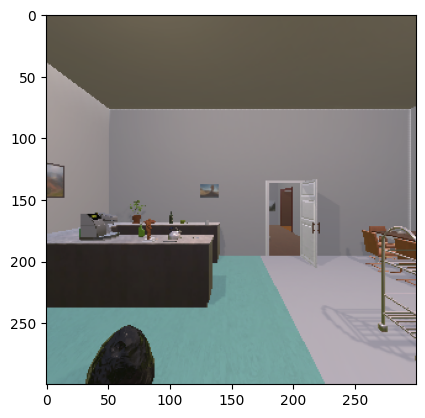

In [4]:
rnd_try = RNDIntrinsicReward()
event = controller.step(
    action="TeleportFull",
    x=spawn["x"],
    y=spawn["y"],
    z=spawn["z"],
    rotation={"x": 0, "y": 90, "z": 0},
    horizon=0,
    standing=True
)
plt.imshow(event.frame)

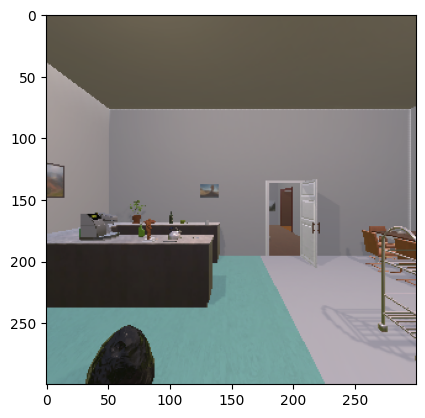

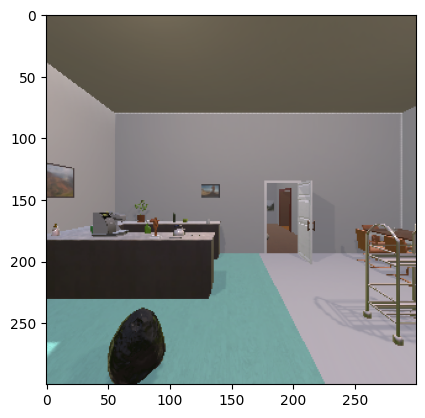

[0.6621645061781168, 0.6447196611808061, 0.6283476785896563, 0.6122230271340372, 0.5973618751038677] 0.6145039124466374


In [5]:
event = controller.step("Pass")

rws = []
for i in range(5):
    rw1 = rnd_try.compute_reward(rnd_try.pre_process_rnd(event))
    rws.append(rw1)
plt.imshow(event.frame)
plt.show()
event = controller.step("MoveBack")
plt.imshow(event.frame)
plt.show()
rw3 = rnd_try.compute_reward(rnd_try.pre_process_rnd(event))
print(rws, rw3)
# plt.imshow(event.frame.copy())

# Start Training

In [4]:
def teleport(controller, target=None):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    if target is None:
        target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [5]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, RNDIntrinsicEnv, ClipEnv, CLIPNovelty, GRPO
from models import Actor, Critic, FrozenResNetEncoder
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [6]:
from rl import save_actor_critic

def train(controller, name: str, ppo: PPO, env: Env, actor_critic: ActorCritic, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    episode_rewards = []
    for upd in range(total_updates):
        buf = RolloutBuffer()
        for mb in range(MINIBATCHES):
            # collect episodes
            episode_seq = []
            episode_reward = 0
            actions_seq = []
            for t in range(1, EPISODE_STEPS + 1):
                obs_t = ppo.obs_from_event(event)  # (C,H,W)
                obs_seq = torch.stack(episode_seq + [obs_t], dim=0).unsqueeze(0).to(device=DEVICE)

                if len(actions_seq) == 0:
                    actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
                
                actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
                logits, value = ppo.act_and_value(obs_seq, actions_tensor, actor_critic)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample()
                logp = dist.log_prob(action_idx)
                
                action_idx, logp = action_idx.item(), logp.item()
                event, reward = env.step_env(controller, action_idx)
                done = t == EPISODE_STEPS

                # store one step
                buf.add(obs_t, action_idx, logp, reward, value, done)
                episode_seq.append(obs_t)
                rewards.append(reward)
                actions_seq.append(action_idx)
                
                episode_reward += reward / EPISODE_STEPS

                # 50% chance of teleport
                if done and np.random.rand() > 0.5:
                    event = teleport(controller)
                    env.reset()
            episode_rewards.append(episode_reward)
                
        ppo.ppo_update(buf, actor_critic)
        save_actor_critic(actor_critic, name)
        
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")
        plt.plot(rewards)
        plt.show()
        plt.plot(episode_rewards)
        plt.show()
    return buf, rewards

In [7]:
rnd_reward = RNDIntrinsicReward()
rnd_intrinsic_env = RNDIntrinsicEnv(rnd_reward)
rnd_actor_critic = ActorCritic()
ppo = PPO(0.08)
buf, rewards = train(controller, "clip_actor_critic_checkpoint_lstm.pt", ppo, rnd_intrinsic_env, rnd_actor_critic, 1)

TypeError: ActorCritic.__init__() missing 3 required positional arguments: 'encoder', 'actor', and 'critic'

# CLIP Novelty - Transformer

In [7]:
ENTROPY_COEF = 0.02

ppo = PPO(ENTROPY_COEF)
grpo = GRPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = Actor(FEAT_DIM, NUM_ACTIONS, n_layers=4)
critic = Critic(FEAT_DIM, n_layers=4)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


In [12]:
from rl import load_actor_critic

load_actor_critic(clip_actor_critic,  "data/clip_actor_critic_checkpoint_smooth_topk_autoreg_action.pt")

[🔁] Actor-Critic checkpoint loaded from data/clip_actor_critic_checkpoint_smooth_topk_autoreg_action.pt


[PPO] Epoch 0: Loss=26.0838, Policy=-0.0001, Value=52.2083
[PPO] Epoch 10: Loss=2.5764, Policy=0.0066, Value=5.1784
[PPO] Epoch 20: Loss=2.2393, Policy=-0.0188, Value=4.5563
[PPO] Epoch 30: Loss=1.5454, Policy=-0.0210, Value=3.1733
[PPO] Epoch 40: Loss=1.1832, Policy=-0.0217, Value=2.4502
Approx KL Learned: 0.004813161678612232
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_smooth_topk_autoreg_action.pt
Update 1/1 — steps: 1024


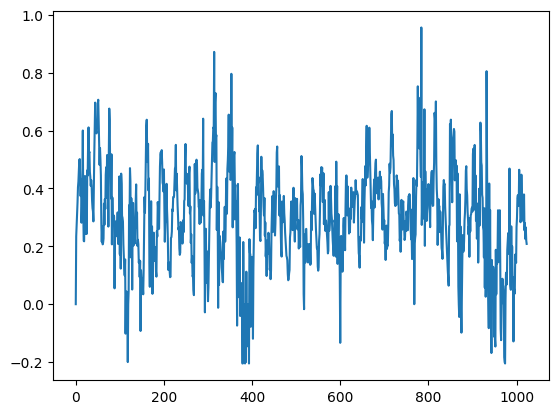

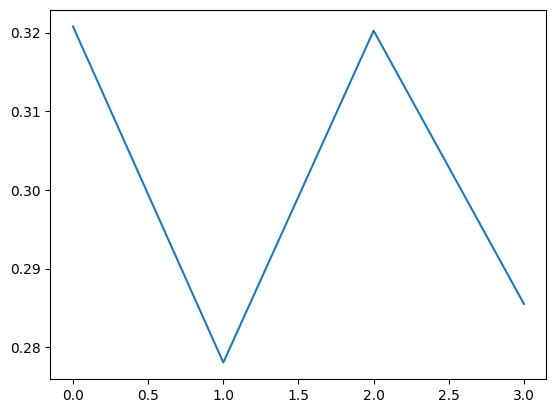

In [8]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_smooth_topk_autoreg_action.pt", ppo, clip_env, clip_actor_critic, 1)

In [18]:
from rl import save_actor_critic

GROUP_SIZE = 4

def train_grpo(controller, name, grpo: GRPO, env: Env, actor_critic: ActorCritic, total_updates=10):

    rewards = []
    episode_rewards = []

    for upd in range(total_updates):

        buf = RolloutBuffer()

        for mb in range(MINIBATCHES):

            # ---- 1) Reset environment ONCE per group ----
            event = controller.step("Pass")
            env.reset()

            # snapshot starting position so every rollout begins identical
            start_pos = event.metadata["agent"]["position"]

            # ---- 2) Run GROUP_SIZE rollouts from SAME STATE ----
            for g in range(GROUP_SIZE):

                # teleport back to start (same initial state)
                event = teleport(controller, start_pos)
                env.reset()

                episode_seq = []
                actions_seq = []
                ep_reward = 0

                for t in range(1, EPISODE_STEPS+1):

                    obs_t = grpo.obs_from_event(event)
                    obs_seq = torch.stack(episode_seq + [obs_t], dim=0).unsqueeze(0).to(DEVICE)

                    if len(actions_seq) == 0:
                        actions_seq.append(NUM_ACTIONS)  # start token

                    actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)

                    logits = grpo.act(obs_seq, actions_tensor, actor_critic)
                    dist = torch.distributions.Categorical(logits=logits)
                    action_idx = dist.sample()
                    logp = dist.log_prob(action_idx)

                    action_idx = action_idx.item()
                    logp = logp.item()

                    event, reward = env.step_env(controller, action_idx)

                    done = (t == EPISODE_STEPS)

                    buf.add(obs_t, action_idx, logp, reward, 0.0, done)
                    rewards.append(reward)

                    episode_seq.append(obs_t)
                    actions_seq.append(action_idx)
                    ep_reward += reward / EPISODE_STEPS

                episode_rewards.append(ep_reward)

        # ---- 3) Update using GRPO ----
        grpo.grpo_update(buf, actor_critic)
        save_actor_critic(actor_critic, name)

        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")
        plt.plot(rewards); plt.show()
        plt.plot(episode_rewards); plt.show()

    return buf, rewards

In [ ]:
buf, rewards = train_grpo(controller, "clip_actor_critic_checkpoint_smooth_topk_autoreg_action.pt", grpo, clip_env, clip_actor_critic, 20)

# CLIP Novelty - LSTM

In [ ]:
from models import LSTMActor, LSTMCritic

In [ ]:
ENTROPY_COEF = 0.0

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = LSTMActor(FEAT_DIM, NUM_ACTIONS)
critic = LSTMCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)
# buf, rewards = train(controller, ppo, clip_env, clip_actor_critic, 20)

In [ ]:
ENTROPY_COEF = 0.04
buf, rewards = train(controller, clip_env, clip_actor_critic, 20)

NameError: name 'train' is not defined

In [162]:
save_actor_critic(clip_actor_critic, "clip_actor_critic_checkpoint_clip_embed.pt")

[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_clip_embed.pt


In [ ]:
house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [9]:
from rl import load_actor_critic
load_actor_critic(clip_actor_critic, "data/clip_actor_critic_checkpoint_smooth_topk_autoreg_action.pt", device=DEVICE)

[🔁] Actor-Critic checkpoint loaded from data/clip_actor_critic_checkpoint_smooth_topk_autoreg_action.pt


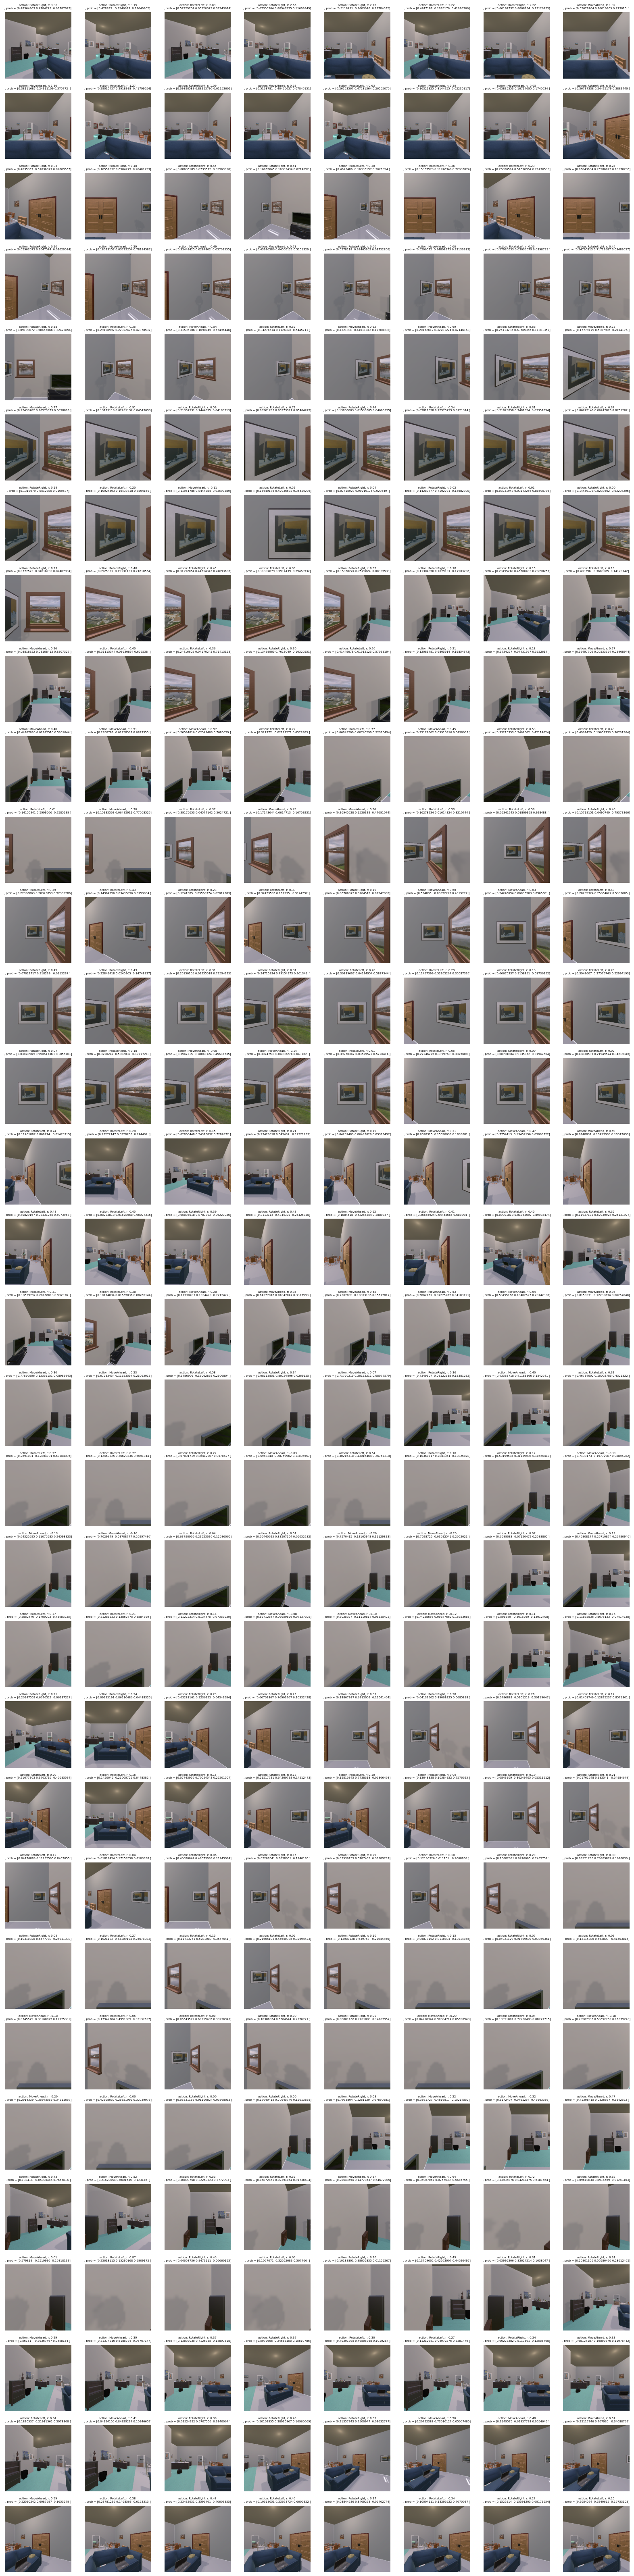

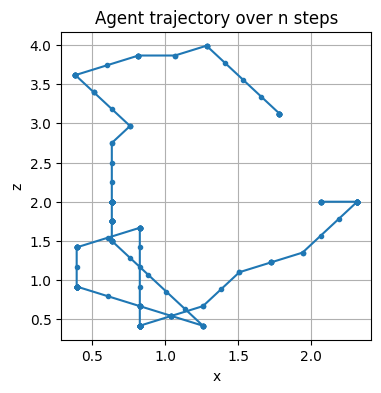

deque([tensor([[[0.6549, 0.6510, 0.6510,  ..., 0.3804, 0.3804, 0.3804],
                [0.6549, 0.6510, 0.6510,  ..., 0.3804, 0.3804, 0.3804],
                [0.6549, 0.6510, 0.6510,  ..., 0.3804, 0.3804, 0.3843],
                ...,
                [0.6039, 0.6039, 0.6039,  ..., 0.2392, 0.2353, 0.2353],
                [0.6039, 0.6039, 0.6039,  ..., 0.2392, 0.2392, 0.2392],
                [0.6039, 0.6039, 0.6039,  ..., 0.2431, 0.2431, 0.2392]],
       
               [[0.6196, 0.6196, 0.6196,  ..., 0.3569, 0.3569, 0.3569],
                [0.6196, 0.6196, 0.6196,  ..., 0.3569, 0.3569, 0.3569],
                [0.6196, 0.6196, 0.6196,  ..., 0.3569, 0.3569, 0.3569],
                ...,
                [0.5882, 0.5882, 0.5882,  ..., 0.2980, 0.2980, 0.2941],
                [0.5882, 0.5882, 0.5882,  ..., 0.2980, 0.2980, 0.2980],
                [0.5882, 0.5882, 0.5882,  ..., 0.3020, 0.2980, 0.2980]],
       
               [[0.6078, 0.6078, 0.6078,  ..., 0.2980, 0.2980, 0.2980],
    

In [17]:
from cons import ACTIONS
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
def inference(get_distribution: Callable[[torch.Tensor, ActorCritic], torch.distributions.Categorical], init_position: dict[str, float], plot=True):
    n = 256
    n_row = 32
    positions = []

    plt.figure(figsize=(n // n_row * 2, n_row * 2))
    event = teleport(controller, init_position)
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)
    for t in range(1, n + 1):
        obs_t = ppo.obs_from_event(event)  # (C,H,W)
        obs_seq = torch.stack(list(episode_seq) + [obs_t], dim=0).unsqueeze(0)
        
        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
        actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
        dist = get_distribution(obs_seq, actions_tensor, clip_actor_critic)
        action_idx = dist.sample()
        # action_idx = np.random.randint(0,4)

        event, reward = clip_env.step_env(controller, action_idx)
        done = t == EPISODE_STEPS

        # Extract agent position from metada
        # ta
        pos = event.metadata["agent"]["position"]
        positions.append((pos["x"], pos["z"]))  # store x,z
        episode_seq.append(obs_t)
        actions_seq.append(action_idx)
        if plot:
            # Plot frame and action
            plt.subplot(n_row, n // n_row, t)
            plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}" + "\n, prob = " + f"{torch.exp(dist.log_prob(torch.tensor([0, 1, 2], device=DEVICE))).cpu().numpy()}", fontsize=5)
            plt.axis(False)
            plt.imshow(event.frame)
    if plot:
        plt.tight_layout()
        plt.show()
        
        # ---- Plot 2D trajectory of the agent ----
        positions = np.array(positions)
        plt.figure(figsize=(4, 4))
        plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
        plt.xlabel("x")
        plt.ylabel("z")
        plt.title("Agent trajectory over n steps")
        plt.grid(True)
        plt.show()

    return episode_seq

def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    return dist

event = teleport(controller)
init_pos = event.metadata["agent"]["position"]
inference(get_distributions, init_pos)

In [14]:
import clip

model, preprocess = clip.load("ViT-B/32", device=DEVICE)

In [16]:
import torch
import torch.nn.functional as F
import random

def preprocess_clip(x):
    # Resize to CLIP resolution
    x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
    # Normalize (CLIP standard mean/std)
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=x.device).view(1, 3, 1, 1)
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=x.device).view(1, 3, 1, 1)
    return (x - mean) / std

def get_average(input_img):
    # ---- 1. Sample 50 random images ----
    n = min(50, len(input_img))
    indices = random.sample(range(len(input_img)), n)
    imgs = torch.stack([input_img[i] for i in indices]).to(DEVICE)  # (50, 3, H, W)

    # ---- 2. Preprocess for CLIP ----
    imgs_clip = preprocess_clip(imgs).half()  # normalized, resized

    # ---- 3. Encode with CLIP visual encoder ----
    with torch.no_grad():
        embeds = model.visual(imgs_clip)       # (50, D)
        embeds = embeds / embeds.norm(dim=-1, keepdim=True)  # normalize to unit sphere

    # ---- 4. Compute cosine similarity ----
    sim_matrix = embeds @ embeds.T             # (50, 50)
    # Optional: remove self-similarity (diagonal = 1)
    sim_matrix.fill_diagonal_(0)

    # ---- 5. Summary statistics ----
    mean_sim = sim_matrix.mean().item()

    return mean_sim

for i in range(5):

    event = teleport(controller)
    init_pos = event.metadata["agent"]["position"]
    
    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
        dist = torch.distributions.Categorical(logits=logits)
        return dist

    policy = inference(get_distributions, init_pos, plot=False)

    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        dist = torch.distributions.Categorical(probs=torch.tensor([0.5, 0.25, 0.25], device=DEVICE))
        return dist

    rand_policy = inference(get_distributions, init_pos, plot=False)

    mean_policies = []
    mean_rands = []
    for i in range(10):
        mean_policy = get_average(policy)
        mean_rand = get_average(rand_policy)
        mean_policies.append(mean_policy)
        mean_rands.append(mean_rand)
    
    print("Policy: " + str(np.mean(np.array(mean_policies))))
    print("Rand: " + str(np.mean(np.array(mean_rands))))



Policy: 0.863427734375
Rand: 0.8634765625
Policy: 0.868701171875
Rand: 0.8294921875
Policy: 0.885205078125
Rand: 0.80732421875
Policy: 0.81435546875
Rand: 0.807958984375
Policy: 0.877001953125
Rand: 0.8798828125


<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

In [ ]:
controller.stop()